## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [7]:
from IPython import display

def experiment(network, optimizer, loss_func, n_epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    def train(epoch):
        network.train()
        batch_idx = 0
        train_loss = 0
        correct = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = network.forward(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            # train_losses.append(loss.item())
            train_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        accuracy = 100. * correct / len(fmnist_dataset_train)
        train_accuracies.append(accuracy)

    def test():
        network.eval()
        test_loss = 0
        correct = 0
        dataset_len = len(fmnist_dataset_test)
        with torch.no_grad():
            for data, target in test_loader:
                output = network.forward(data)
                loss_val = loss_func(output, target, size_average=False).item()
                # test_losses.append(loss_val)
                test_loss += loss_val
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= dataset_len
        test_losses.append(test_loss)
        accuracy = 100. * correct / dataset_len
        display.clear_output(wait=True)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, dataset_len, accuracy))
        test_accuracies.append(accuracy)

    for epoch in range(1, n_epochs + 1):
        print('Epoch: {}\n'.format(epoch))
        train(epoch)
        test()
        # display.clear_output(wait=True)
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)    
        plt.title("Losses")
        plt.xlabel("#epoch")
        plt.ylabel("loss")
        plt.plot(train_losses, 'b', label='train', c='C1')
        plt.plot(test_losses, 'b', label='test', c='C2')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title("Accuracies")
        plt.xlabel("#epoch")
        plt.ylabel("accuracy")
        plt.plot(train_accuracies, 'b', label='train', c='C1')
        plt.plot(test_accuracies, 'b', label='test', c='C2')
        plt.legend()
        plt.show()



### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [8]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out


In [9]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
            Linear-4                   [-1, 10]           7,850
        LogSoftmax-5                   [-1, 10]               0
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.38
Estimated Total Size (MB): 2.40
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Your experiments come here:


Test set: Avg. loss: 0.3663, Accuracy: 8853/10000 (89%)



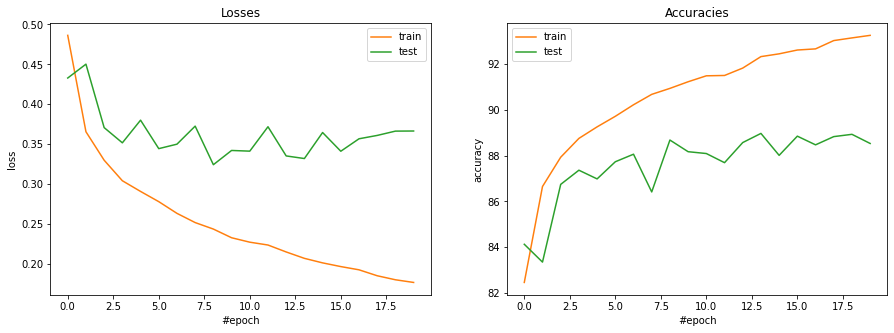

In [10]:
model = TinyNeuralNetwork()
# opt = # YOUR CODE HERE
# loss_func = # YOUR CODE HERE

# Your experiments, training and validation loops here
import torch.nn.functional as F
import torch.optim as optim

learning_rate = 3e-03
# opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss = F.nll_loss
n_epochs = 20

experiment(model, opt, loss, n_epochs)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [11]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [12]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
            Linear-4                  [-1, 784]         615,440
              ReLU-5                  [-1, 784]               0
            Linear-6                   [-1, 10]           7,850
        LogSoftmax-7                   [-1, 10]               0
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 4.73
Estimated Total Size (MB): 4.76
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Test set: Avg. loss: 0.4073, Accuracy: 8835/10000 (88%)



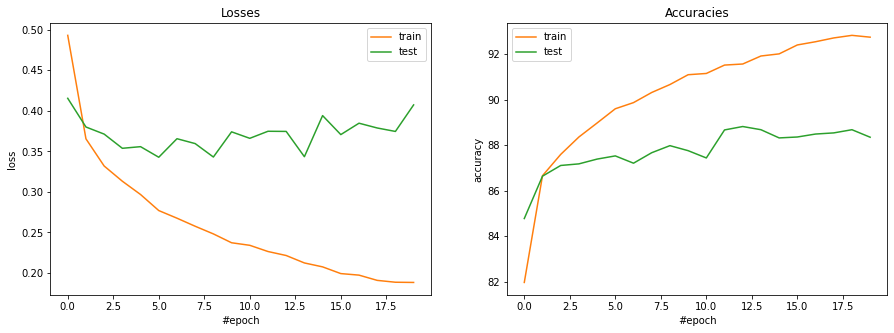

In [13]:
model = OverfittingNeuralNetwork()
# opt = # YOUR CODE HERE
# loss_func = # YOUR CODE HERE

# Your experiments, come here
learning_rate = 3e-03
# opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss = F.nll_loss
n_epochs = 20

experiment(model, opt, loss, n_epochs)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [14]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape, momentum=1.-0.9, affine=True),
            nn.Dropout(0.5),
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape, momentum=1.-0.9, affine=True),
            nn.Dropout(0.5),
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [15]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
       BatchNorm1d-4                  [-1, 784]           1,568
           Dropout-5                  [-1, 784]               0
            Linear-6                  [-1, 784]         615,440
              ReLU-7                  [-1, 784]               0
       BatchNorm1d-8                  [-1, 784]           1,568
           Dropout-9                  [-1, 784]               0
           Linear-10                   [-1, 10]           7,850
       LogSoftmax-11                   [-1, 10]               0
Total params: 1,241,866
Trainable params: 1,241,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Test set: Avg. loss: 0.3473, Accuracy: 8767/10000 (88%)



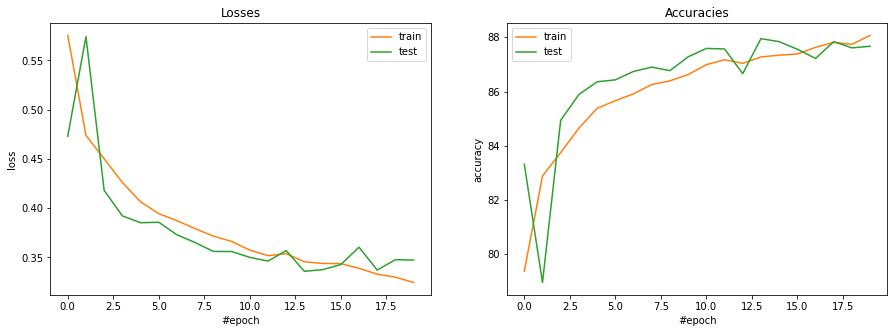

In [16]:
model = FixedNeuralNetwork()
# opt = # YOUR CODE HERE
# loss_func = # YOUR CODE HERE

# Your experiments, come here
learning_rate = 3e-03
# opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss = F.nll_loss
n_epochs = 20

experiment(model, opt, loss, n_epochs)

### Conclusions:
With raising of epochs amount model adopts to train dataset. This proccess is called _overfitting_: test loss raises and test accuraccy decreases. You can see it (in task 1) after approximately 15 epoch. More complex models are more addicted to overfitting. To demonstrate it I created more complex model in task 2 with additional linear layer. You can see it on the plot after task 2. To fix overfitting we can use regularization layers (batch norm, dropout). Effect you can see on the plot after task 3.